In [1]:
%reset
import sys, os
# del os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]
# del os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = '0.95'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
# os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
sys.path.append('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




/tmp/ipykernel_2231056/3084209893.py:12: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.1
sim_params_dict['log10_Mstar0_theta_co'] = 15.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
sim_params_dict['nu_theta_ej_M'] = -0.2
sim_params_dict['nu_theta_ej_z'] = 0.05

sim_params_dict['log10_Mc0'] = 15.0
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = -2.5
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 12, 32
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 2.5, 20
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
# halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 12.0, 15.5, 28
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 16
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 5
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits')
theta_data = df_data['xip'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
# analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 128
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.0
analysis_dict['want_like_diff'] = True
analysis_dict['calc_nfw_only'] = True

other_params_dict = {}
other_params_dict['A_IA'] = 0.1
other_params_dict['eta_IA'] = 0.0
other_params_dict['z0_IA'] = 0.62
other_params_dict['C1_bar'] = 5e-14
# for jb in range(nz_info_dict['nbins']):
#     other_params_dict['Delta_z_bias_bin%d'%(jb+1)] = 0.0
#     other_params_dict['mult_shear_bias_bin%d'%(jb+1)] = 0.0
other_params_dict['Delta_z_bias_array'] = jnp.zeros(nz_info_dict['nbins'])
other_params_dict['mult_shear_bias_array'] = jnp.zeros(nz_info_dict['nbins'])



In [3]:
import copy
from tqdm import tqdm
from get_corr_func_jit import get_corrfunc_BCMP
get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict, verbose_time=False)




In [4]:
import pickle as pk

# probe = 'xip_xim' 
probe = 'gty'
# probe = 'all'

# cov_total = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/total_cov_gty_xip_xim_Y1.pk', 'rb'))['cov_total']
cov_total = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/total_cov_gty_xip_xim_Y6.pk', 'rb'))['cov_total']
cov_total = jnp.array(cov_total)
if probe == 'xip_xim':
    cov_total = cov_total[100:, 100:]
elif probe == 'gty':
    cov_total = cov_total[:100, :100]
P = jnp.linalg.inv(cov_total)




In [5]:
df_cs = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
bin1_vals =  df_cs['xip'].data['BIN1'][::20]
bin2_vals =  df_cs['xip'].data['BIN2'][::20]
biny_vals = np.array([1,2,3,4,5])

# index_gty = {}
index_gty = []
for js in range(100):
    # index_gty[js] = [js%20 ,js//20]
    index_gty.append([js%20 ,js//20])
index_gty = jnp.array(index_gty)
# index_xip = {}
index_xip = []
for js in range(300):
    binv = js//20
    thetav = js%20
    # index_xip[js] = [thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1]
    index_xip.append([thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1])
index_xip = jnp.array(index_xip)
# index_xim = {}
index_xim = []
for js in range(300):
    binv = js//20
    thetav = js%20
    # index_xim[js] = [thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1]   
    index_xim.append([thetav ,bin1_vals[binv]-1, bin2_vals[binv]-1])
index_xim = jnp.array(index_xim)

# mean_dv_all = np.zeros(700)
# for jy in range(len(biny_vals)):
#     mean_dv_all[jy*20:(jy+1)*20] = get_corrfunc_BCMP_test.gty_out_mat[:,jy]

# for jk in  range(len(bin1_vals)):
#     b1 = int(bin1_vals[jk] - 1)
#     b2 = int(bin2_vals[jk] - 1)
#     mean_dv_all[100 + jk*20:100 + (jk+1)*20] = get_corrfunc_BCMP_test.xip_out_mat[:,b1,b2]
#     mean_dv_all[400 + jk*20:400 + (jk+1)*20] = get_corrfunc_BCMP_test.xim_out_mat[:,b1,b2]



In [6]:
def get_gty_from_index(index):
    index_val = index_gty[index]
    return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

def get_xip_from_index(index):
    index_val = index_xip[index]
    return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

def get_xim_from_index(index):
    index_val = index_xim[index]
    return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

gty_val = vmap(get_gty_from_index)(np.arange(100))
xip_val = vmap(get_xip_from_index)(np.arange(300))
xim_val = vmap(get_xim_from_index)(np.arange(300))

if probe == 'xip_xim':
    mean_dv_val = jnp.concatenate([xip_val, xim_val])
elif probe == 'gty':
    mean_dv_val = gty_val
else:
    mean_dv_val = jnp.concatenate([gty_val, xip_val, xim_val])



In [7]:
# mean_dv_val_wIA = copy.deepcopy(mean_dv_val)
# mean_dv_val

# mean_dv_val.shape

snr_y1 = jnp.sqrt(mean_dv_val.T @ P @ mean_dv_val)
print(snr_y1)



138.3885871364987


In [8]:
# pl.figure()
# pl.plot(mean_dv_val)
# pl.plot(mean_dv_val - mean_dv_val_wIA)
# # pl.xscale('log')
# pl.yscale('log')

# 238, 
snr_y1_all = 238.0
snr_y1_shear = 234.0

snr_y6_all = 390
snr_y6_shear = 380


In [9]:
# mean_dv_val
# pl.figure()
# pl.plot(mean_dv_val)
# # pl.xscale('log')
# pl.yscale('log')

np.sqrt(234**2 + 80**2)


247.2973918180295

In [10]:
# params_vary_names = ['eta_star','alpha_nt', 'theta_ej_0', 'theta_co_0', 'nu_theta_ej_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0', 'mu_beta', 'delta_rhogas', 'gamma_rhogas']
# params_vary_names = ['theta_ej_0', 'theta_co_0', 'nu_theta_ej_M', 'gamma_rhogas']


In [11]:
# import jax
# import copy
# import jax_cosmo as jc
# params_vary_names = ['theta_ej_0', 'gamma_rhogas']
# @jax.jit
# def likelihood(p):
#     # params_vary_names = ['theta_ej_0', 'theta_co_0', 'nu_theta_ej_M', 'gamma_rhogas']

#     sim_params_dict_vary = copy.deepcopy(sim_params_dict)
#     for jp in range(len(params_vary_names)):
#         sim_params_dict_vary[params_vary_names[jp]] = p[jp]

#     get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict, verbose_time=False)

#     def get_gty_from_index(index):
#         index_val = index_gty[index]
#         return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

#     def get_xip_from_index(index):
#         index_val = index_xip[index]
#         return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

#     def get_xim_from_index(index):
#         index_val = index_xim[index]
#         return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

#     gty_val = vmap(get_gty_from_index)(np.arange(100))
#     xip_val = vmap(get_xip_from_index)(np.arange(300))
#     xim_val = vmap(get_xim_from_index)(np.arange(300))

#     mu = jnp.concatenate([gty_val, xip_val, xim_val])


#     # Return likelihood value assuming constant covariance, so we stop the gradient
#     # at the level of the precision matrix, and we will not include the logdet term
#     # in the likelihood
#     r = mean_dv_val - mu
#     return -0.5 * r.T @ jc.sparse.sparse_dot_vec(P, r)


In [12]:
# hessian_loglik = jax.jit(jax.hessian(likelihood))


In [13]:
cosmo_params_vary_names = ['Om0', 'Ob0', 'H0', 'ns', 'sigma8']
sims_params_vary_names1 = ['eta_star','alpha_nt', 'theta_ej_0', 'theta_co_0']
sims_params_vary_names2 = ['nu_theta_ej_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0']
sims_params_vary_names3 = ['mu_beta', 'delta_rhogas', 'gamma_rhogas']
IA_params_vary_names = ['A_IA', 'eta_IA']
mult_shear_vary_names = ['mult_shear_bias_bin1', 'mult_shear_bias_bin2', 'mult_shear_bias_bin3', 'mult_shear_bias_bin4', 'mult_shear_bias_bin5'] 
Delta_shear_vary_names = ['Delta_z_bias_bin1', 'Delta_z_bias_bin2', 'Delta_z_bias_bin3', 'Delta_z_bias_bin4', 'Delta_z_bias_bin5']


# params_fid = np.zeros(len(cosmo_params_vary_names) + len(sims_params_vary_names) + len(IA_params_vary_names) + len(other_params_vary_names))
# for jp in range(len(cosmo_params_vary_names)):
#     params_fid[jp] = sim_params_dict['cosmo'][cosmo_params_vary_names[jp]]

# for jp in range(len(sims_params_vary_names)):
#     params_fid[len(cosmo_params_vary_names) + jp] = sim_params_dict[sims_params_vary_names[jp]]

# for jp in range(len(IA_params_vary_names)):
#     params_fid[len(cosmo_params_vary_names) + len(sims_params_vary_names) + jp] = other_params_dict[IA_params_vary_names[jp]]

# params_fid = jnp.array(params_fid)




In [15]:
import jax 
from tqdm import tqdm

# @jax.jit
def get_mean_cosmo(p):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    for jp in range(len(cosmo_params_vary_names)):
        sim_params_dict_vary['cosmo'][cosmo_params_vary_names[jp]] = p[jp]
    
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict_vary, verbose_time=False)

    def get_gty_from_index(index):
        index_val = index_gty[index]
        return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

    def get_xip_from_index(index):
        index_val = index_xip[index]
        return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

    def get_xim_from_index(index):
        index_val = index_xim[index]
        return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

    gty_val = vmap(get_gty_from_index)(np.arange(100))
    xip_val = vmap(get_xip_from_index)(np.arange(300))
    xim_val = vmap(get_xim_from_index)(np.arange(300))

    if probe == 'xip_xim':
        mu = jnp.concatenate([xip_val, xim_val])
    elif probe == 'gty':
        mu = gty_val
    else:
        mu = jnp.concatenate([gty_val, xip_val, xim_val])

    return mu




In [33]:

cosmo_params_vary_names_all = ['Om0', 'Ob0', 'H0', 'ns', 'sigma8']
# cosmo_params_vary_names_all = ['Om0', 'Ob0', 'sigma8']
# cosmo_params_vary_names_all = ['Om0']

cosmo_params_fid_all = np.zeros(len(cosmo_params_vary_names_all))
for jp in range(len(cosmo_params_vary_names_all)):
    cosmo_params_fid_all[jp] = sim_params_dict['cosmo'][cosmo_params_vary_names_all[jp]]

dmu_cosmo_all = np.zeros((len(mean_dv_val), len(cosmo_params_vary_names_all)))
for jp in tqdm(range(len(cosmo_params_vary_names_all))):
    cosmo_params_vary_names = [cosmo_params_vary_names_all[jp]]
    params_fid = jnp.array([sim_params_dict['cosmo'][cosmo_params_vary_names_all[jp]]])

    jac_mean = jax.jit(jax.jacfwd(get_mean_cosmo))
    dmu_cosmo = jac_mean(params_fid)
    dmu_cosmo_all[:, jp] = dmu_cosmo[:,0]




  0%|          | 0/5 [00:00<?, ?it/s]2024-02-17 20:34:29.292237: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 50.72GiB (rounded to 54465338624)requested by op 
2024-02-17 20:34:29.292671: W external/tsl/tsl/framework/bfc_allocator.cc:497] **__________________________________________________________________________________________________
2024-02-17 20:34:29.302879: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 54465338512 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:    36.5KiB
        maybe_live_out allocation:       800B
     preallocated temp allocation:   50.72GiB
  preallocated temp fragmentation:     3.8KiB (0.00%)
                 total allocation:   50.72GiB
              total fragmentation:   108.6KiB (0.00%)
Pea

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 54465338512 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:    36.5KiB
        maybe_live_out allocation:       800B
     preallocated temp allocation:   50.72GiB
  preallocated temp fragmentation:     3.8KiB (0.00%)
                 total allocation:   50.72GiB
              total fragmentation:   108.6KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 2:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 3:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 4:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 5:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 6:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 7:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 8:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 9:
		Size: 4.38GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mgas))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,64]
		==========================

	Buffer 10:
		Size: 4.31GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mcga))/jit(trapz)/add" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=255
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,63]
		==========================

	Buffer 11:
		Size: 4.31GiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mcga))/jit(trapz)/add" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=255
		XLA Label: fusion
		Shape: f64[32,16,20,28,32,63]
		==========================

	Buffer 12:
		Size: 280.00MiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mcga))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[1,32,20,28,32,64]
		==========================

	Buffer 13:
		Size: 280.00MiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mcga))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,20,28,32,64]
		==========================

	Buffer 14:
		Size: 280.00MiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mcga))/mul" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=254
		XLA Label: fusion
		Shape: f64[32,20,28,32,64]
		==========================

	Buffer 15:
		Size: 280.00MiB
		Operator: op_name="jit(get_mean_cosmo)/jit(main)/vmap(jvp(vmap(vmap(vmap(vmap(jit(get_zeta)))))))/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/exp" source_file="/mnt/home/spandey/ceph/GODMAX/src/get_BCMP_profile_jit.py" source_line=382
		XLA Label: fusion
		Shape: f64[1,32,20,28,32,64]
		==========================



In [14]:
import jax 
from tqdm import tqdm

@jax.jit
def get_mean_sims(p):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    for jp in range(len(sim_param_vary_names)):
        sim_params_dict_vary[sim_param_vary_names[jp]] = p[jp]
    
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict_vary, verbose_time=False)

    def get_gty_from_index(index):
        index_val = index_gty[index]
        return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

    def get_xip_from_index(index):
        index_val = index_xip[index]
        return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

    def get_xim_from_index(index):
        index_val = index_xim[index]
        return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

    gty_val = vmap(get_gty_from_index)(np.arange(100))
    xip_val = vmap(get_xip_from_index)(np.arange(300))
    xim_val = vmap(get_xim_from_index)(np.arange(300))

    if probe == 'xip_xim':
        mu = jnp.concatenate([xip_val, xim_val])
    elif probe == 'gty':
        mu = gty_val
    else:
        mu = jnp.concatenate([gty_val, xip_val, xim_val])

    return mu

# sims_params_vary_names_all = ['eta_star','alpha_nt', 'theta_ej_0', 'theta_co_0','nu_theta_ej_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0','mu_beta', 'delta_rhogas', 'gamma_rhogas']

# sims_params_vary_names_all = ['eta_star','alpha_nt', 'theta_ej_0', 'theta_co_0','nu_theta_ej_M', 'nu_theta_ej_z', 'nu_z', 'log10_Mc0','mu_beta', 'delta_rhogas', 'gamma_rhogas']
# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0', 'delta_rhogas', 'gamma_rhogas']
# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0', 'gamma_rhogas','mu_beta','eta_star','alpha_nt', 'log10_Mc0','nu_theta_ej_M']
# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0', 'gamma_rhogas','mu_beta','eta_star','alpha_nt', 'log10_Mc0','nu_theta_ej_M']
# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas', 'delta_rhogas','mu_beta','nu_theta_ej_M','eta_star','alpha_nt']
# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta','nu_theta_ej_M','eta_star','alpha_nt']

sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0','nu_z', 'nu_theta_ej_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt', 'nu_theta_ej_M']

# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0']


# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']
sims_params_fid_all = np.zeros(len(sims_params_vary_names_all))
for jp in range(len(sims_params_vary_names_all)):
    sims_params_fid_all[jp] = sim_params_dict[sims_params_vary_names_all[jp]]

dmu_sims_all = np.zeros((len(mean_dv_val), len(sims_params_vary_names_all)))
for jp in tqdm(range(len(sims_params_vary_names_all))):
    sim_param_vary_names = [sims_params_vary_names_all[jp]]
    params_fid = jnp.array([sim_params_dict[sims_params_vary_names_all[jp]]])

    jac_mean = jax.jit(jax.jacfwd(get_mean_sims))
    dmu_sim = jac_mean(params_fid)
    dmu_sims_all[:,jp] = dmu_sim[:,0]

F_sims = jnp.matmul(dmu_sims_all.T, jnp.matmul(P, dmu_sims_all))
# print(np.linalg.cond(F_sims))
cov_sims_params = np.linalg.inv(F_sims)
print(np.sqrt(np.diag(cov_sims_params)))




  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:47<00:00, 22.78s/it]

[3.70170261e+00 4.10738755e-03 2.52110944e+00 2.38984855e-04
 1.07388687e+00 1.01698779e+00 3.50502477e+01 5.97776657e-02
 3.24867705e-01 1.28473223e+00]


In [162]:
# F_sims
# print(np.linalg.cond(F_sims))
# [1.19154918e+00 1.12868658e-03 1.44971859e+00 7.12045359e-01
#  3.77011455e-02 2.69427175e+00 2.00689285e-02 2.41487186e-02]


In [163]:
# # [0.81274005 0.00220525 1.04479519 0.5617703  0.21365927 0.71319808
# #  0.03936394 0.89099363]
# pl.figure()
# for jp in range(len(sims_params_vary_names_all)):
#     pl.plot(np.abs(dmu_sims_all[:,jp]/mean_dv_val))
# pl.yscale('log')
# # pl.ylim(-1e-5, 1e-5)


In [164]:
import jax 
from tqdm import tqdm

@jax.jit
def get_mean_IA(p):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    for jp in range(len(IA_param_vary_names)):
        other_params_dict_vary[IA_param_vary_names[jp]] = p[jp]
    
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict_vary, verbose_time=False)

    def get_gty_from_index(index):
        index_val = index_gty[index]
        return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

    def get_xip_from_index(index):
        index_val = index_xip[index]
        return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

    def get_xim_from_index(index):
        index_val = index_xim[index]
        return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

    gty_val = vmap(get_gty_from_index)(np.arange(100))
    xip_val = vmap(get_xip_from_index)(np.arange(300))
    xim_val = vmap(get_xim_from_index)(np.arange(300))

    if probe == 'xip_xim':
        mu = jnp.concatenate([xip_val, xim_val])
    elif probe == 'gty':
        mu = gty_val
    else:
        mu = jnp.concatenate([gty_val, xip_val, xim_val])

    return mu

IA_params_vary_names_all = ['A_IA', 'eta_IA']

IA_params_fid_all = np.zeros(len(IA_params_vary_names_all))
for jp in range(len(IA_params_vary_names_all)):
    IA_params_fid_all[jp] = other_params_dict[IA_params_vary_names_all[jp]]

dmu_IA_all = np.zeros((len(mean_dv_val), len(IA_params_vary_names_all)))
for jp in tqdm(range(len(IA_params_vary_names_all))):
    IA_param_vary_names = [IA_params_vary_names_all[jp]]
    params_fid = jnp.array([other_params_dict[IA_params_vary_names_all[jp]]])

    jac_mean = jax.jit(jax.jacfwd(get_mean_IA))
    dmu_IA = jac_mean(params_fid)
    dmu_IA_all[:, jp] = dmu_IA[:, 0]




  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:22<00:00, 11.11s/it]


In [165]:
# dmu_IA_all
# F_IA = jnp.matmul(dmu_IA_all.T, jnp.matmul(P, dmu_IA_all))
# print(F_IA)




In [166]:
import jax 

@jax.jit
def get_mean_mult_shear(p):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    other_params_dict_vary['mult_shear_bias_array'] = p

    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict_vary, verbose_time=False)

    def get_gty_from_index(index):
        index_val = index_gty[index]
        return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

    def get_xip_from_index(index):
        index_val = index_xip[index]
        return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

    def get_xim_from_index(index):
        index_val = index_xim[index]
        return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

    gty_val = vmap(get_gty_from_index)(np.arange(100))
    xip_val = vmap(get_xip_from_index)(np.arange(300))
    xim_val = vmap(get_xim_from_index)(np.arange(300))

    if probe == 'xip_xim':
        mu = jnp.concatenate([xip_val, xim_val])
    elif probe == 'gty':
        mu = gty_val
    else:
        mu = jnp.concatenate([gty_val, xip_val, xim_val])

    return mu

mult_shear_vary_names = ['mult_shear_bias_bin1', 'mult_shear_bias_bin2', 'mult_shear_bias_bin3', 'mult_shear_bias_bin4', 'mult_shear_bias_bin5'] 
params_fid = jnp.zeros(len(mult_shear_vary_names))
jac_mean = jax.jit(jax.jacfwd(get_mean_mult_shear))
dmu_mult_shear_all = jac_mean(params_fid)



In [167]:
import jax 

@jax.jit
def get_mean_bias_Deltaz(p):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    other_params_dict_vary['Delta_z_bias_array'] = p

    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict, other_params_dict_vary, verbose_time=False)

    def get_gty_from_index(index):
        index_val = index_gty[index]
        return get_corrfunc_BCMP_test.gty_out_mat[index_val[0], index_val[1]]

    def get_xip_from_index(index):
        index_val = index_xip[index]
        return get_corrfunc_BCMP_test.xip_out_mat[index_val[0], index_val[1], index_val[2]]

    def get_xim_from_index(index):
        index_val = index_xim[index]
        return get_corrfunc_BCMP_test.xim_out_mat[index_val[0], index_val[1], index_val[2]]

    gty_val = vmap(get_gty_from_index)(np.arange(100))
    xip_val = vmap(get_xip_from_index)(np.arange(300))
    xim_val = vmap(get_xim_from_index)(np.arange(300))

    if probe == 'xip_xim':
        mu = jnp.concatenate([xip_val, xim_val])
    elif probe == 'gty':
        mu = gty_val
    else:
        mu = jnp.concatenate([gty_val, xip_val, xim_val])

    return mu

Delta_shear_vary_names = ['Delta_z_bias_bin1', 'Delta_z_bias_bin2', 'Delta_z_bias_bin3', 'Delta_z_bias_bin4', 'Delta_z_bias_bin5']
params_fid = jnp.zeros(len(Delta_shear_vary_names))
jac_mean = jax.jit(jax.jacfwd(get_mean_bias_Deltaz))
dmu_bias_Deltaz_all = jac_mean(params_fid)



In [168]:
dmu_all = np.concatenate([dmu_cosmo_all, dmu_sims_all, dmu_IA_all, dmu_mult_shear_all, dmu_bias_Deltaz_all], axis=1)
# dmu_all = np.concatenate([dmu_cosmo_all.T, dmu_sims_all.T, dmu_IA_all.T, dmu_mult_shear_all, dmu_bias_Deltaz_all], axis=1)
# dmu_all.shape

F_all = jnp.matmul(dmu_all.T, jnp.matmul(P, dmu_all))

print(F_all.shape)


(27, 27)


In [169]:
# np.linalg.cond(F_all)
F_cosmo = jnp.matmul(dmu_cosmo_all.T, jnp.matmul(P, dmu_cosmo_all))
F_sims = jnp.matmul(dmu_sims_all.T, jnp.matmul(P, dmu_sims_all))
F_IA = jnp.matmul(dmu_IA_all.T, jnp.matmul(P, dmu_IA_all))
F_mult_shear = jnp.matmul(dmu_mult_shear_all.T, jnp.matmul(P, dmu_mult_shear_all))
F_bias_Deltaz = jnp.matmul(dmu_bias_Deltaz_all.T, jnp.matmul(P, dmu_bias_Deltaz_all))

print(np.linalg.cond(F_cosmo))
print(np.linalg.cond(F_sims))
print(np.linalg.cond(F_IA))
print(np.linalg.cond(F_mult_shear))
print(np.linalg.cond(F_bias_Deltaz))



429036491.8882529
286886988.05286455
3117.327774967506
81.85054598056897
4.397148749307751


In [170]:
# np.sqrt(np.linalg.inv(F_IA))


In [171]:
# F_all.shape
fid_params_all = np.concatenate([cosmo_params_fid_all, sims_params_fid_all, IA_params_fid_all, other_params_dict['mult_shear_bias_array'], other_params_dict['Delta_z_bias_array']])


In [172]:
fid_params_all
# fid_params_all
# sims_params_fid_all


array([ 3.10e-01,  4.90e-02,  6.72e+01,  9.50e-01,  8.10e-01,  4.00e+00,
        1.00e-01, -2.50e+00,  5.00e-02,  2.00e+00,  2.10e-01,  1.50e+01,
        3.00e-01,  1.80e-01, -2.00e-01,  1.00e-01,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00])

In [173]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as pl
def plot_contours(fisher, pos, inds=[1,0], nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  i,j = inds
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = pl.gca()

  # Extracts the block we are interested in
  block_cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(block_cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos[[i,j]], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(i)
  s2 = 1.5*nstd*sigma_marg(j)
  ax.set_xlim(pos[i] - s1, pos[i] + s1)
  ax.set_ylim(pos[j] - s2, pos[j] + s2)
  pl.draw()
  return ellip



In [174]:
# Add priors to systematics
import numpy as np
d = np.zeros(F_all.shape[0])
d[F_all.shape[0]-nz_info_dict['nbins']:] = 1/(1e-3)**2
d[F_all.shape[0]-2*nz_info_dict['nbins']:F_all.shape[0]-nz_info_dict['nbins']] = 1/(3e-3)**2

F_all = F_all + np.diag(d)


In [175]:
# fid_params_all = np.concatenate([cosmo_params_fid, sims_params_fid, IA_params_fid, other_params_fid])
# fid_params_all = np.zeros(F_all.shape[0])


In [176]:
import jax_cosmo as jc
# cov = jc.sparse.inv(F_all)
# np.linalg.inv(F_all)
np.linalg.cond(F_all)



6973209052.718622

In [177]:
cov = np.linalg.inv(F_all)
np.diag(cov)



array([2.37237882e-04, 3.51888477e-04, 2.31986925e+02, 2.03060610e-02,
       4.83391029e-04, 3.63437387e+01, 4.65953513e-03, 4.10796747e+01,
       5.61751134e-05, 1.33955467e+01, 8.72986171e+00, 3.78261796e+01,
       1.58598979e-01, 1.10287579e+00, 1.12928422e+01, 2.21300889e-01,
       2.28091100e-01, 8.95061534e-06, 7.82154243e-06, 6.79606443e-06,
       5.35215816e-06, 7.37620509e-06, 9.66818878e-07, 8.47611969e-07,
       8.83829189e-07, 9.14894179e-07, 9.93518008e-07])

In [178]:
# fid_params_all
# mat = fisher
cov = np.linalg.inv(F_all)
np.diag(cov)


array([2.37237882e-04, 3.51888477e-04, 2.31986925e+02, 2.03060610e-02,
       4.83391029e-04, 3.63437387e+01, 4.65953513e-03, 4.10796747e+01,
       5.61751134e-05, 1.33955467e+01, 8.72986171e+00, 3.78261796e+01,
       1.58598979e-01, 1.10287579e+00, 1.12928422e+01, 2.21300889e-01,
       2.28091100e-01, 8.95061534e-06, 7.82154243e-06, 6.79606443e-06,
       5.35215816e-06, 7.37620509e-06, 9.66818878e-07, 8.47611969e-07,
       8.83829189e-07, 9.14894179e-07, 9.93518008e-07])

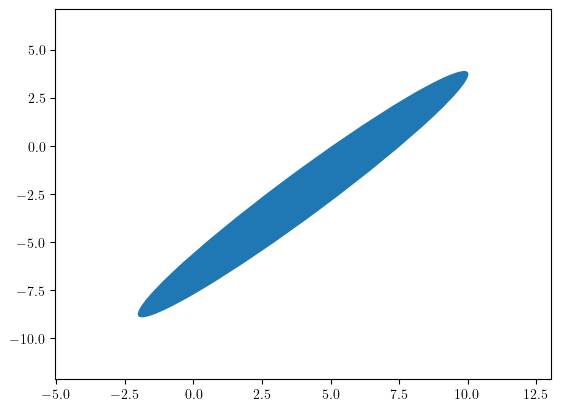

In [179]:
plot_contours(F_all, fid_params_all, inds=[5,7])


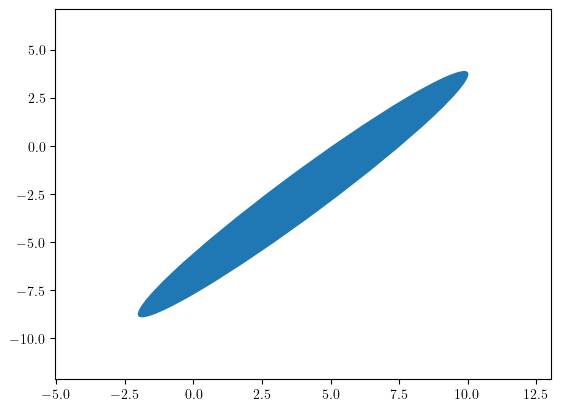

In [180]:
# plot_contours(F_all, fid_params_all, inds=[4,0])
plot_contours(F_all, fid_params_all, inds=[5,7])
# xlabel('Omega_c')
# ylabel('sigma8')


In [181]:
cov = np.linalg.inv(F_all)
mean = fid_params_all
# get samples from this multi dimensional gaussian
samples = np.random.multivariate_normal(mean, cov, 100000)


In [182]:
# F_all
fid_params_all



array([ 3.10e-01,  4.90e-02,  6.72e+01,  9.50e-01,  8.10e-01,  4.00e+00,
        1.00e-01, -2.50e+00,  5.00e-02,  2.00e+00,  2.10e-01,  1.50e+01,
        3.00e-01,  1.80e-01, -2.00e-01,  1.00e-01,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00])

In [183]:
saved = {'samples':samples, 'mean':mean, 'cov':cov, 'F_all':F_all}
import pickle as pk
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_REDUCEDSET.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_REDUCEDSET.pk', 'wb'))

# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_REDUCEDSET_xipxim_only.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_REDUCEDSET_xipxim_only.pk', 'wb'))


# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_xipxim_only.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_gty_only_wFcov.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_xipxim_only.pk', 'wb'))


# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_wFcov.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_xipxim_only_wFcov.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_gty_only_wFcov.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_wFcov.pk', 'wb'))
pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_xipxim_only_wFcov.pk', 'wb'))
# pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_gty_only_wFcov.pk', 'wb'))



Removed no burn in


<Figure size 600x450 with 0 Axes>

<Figure size 600x450 with 0 Axes>

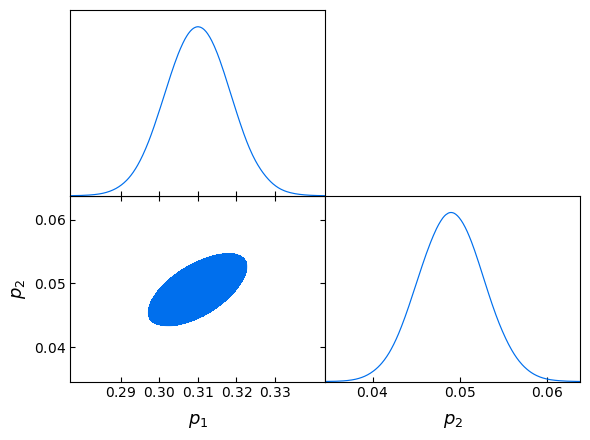

<Figure size 600x450 with 0 Axes>

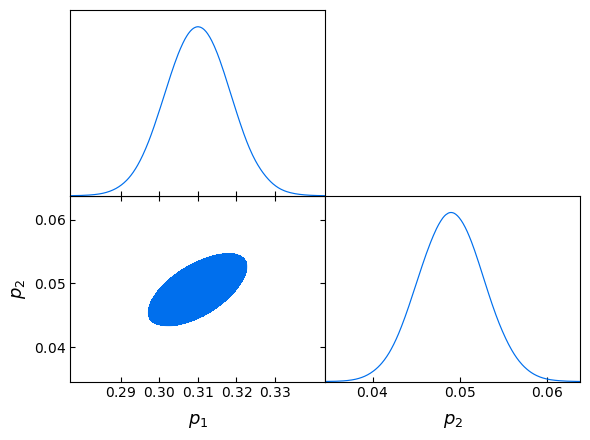

In [63]:
import getdist
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import MixtureND
chain = MCSamples(samples=samples, name_tag='Mixture')
g = plots.get_single_plotter()
# samples.updateSettings({'contours': [0.68]})
g.settings.num_plot_contours = 1

# g = plots.get_subplot_plotter()

g.triangle_plot([chain], params=chain.getParamNames().list()[:2], filled=True)


In [62]:
import matplotlib
%matplotlib inline


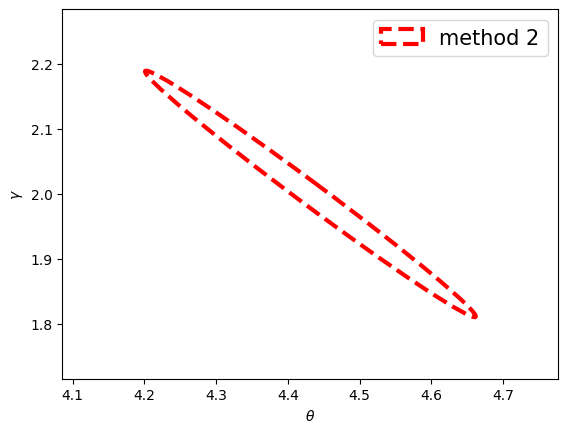

In [21]:
# We can now plot contours obtained so far 
p0_name = r'$\theta$'
p1_name = r'$\gamma$'
# pl.figure()
# plot_contours(F, params, fill=False,color='black',lw=3, label="method 1");
plot_contours(F_2, params_fid, fill=False, color='red', lw=3, linestyle='dashed', label="method 2");
pl.xlabel(p0_name)
pl.ylabel(p1_name);
pl.legend(fontsize=15)


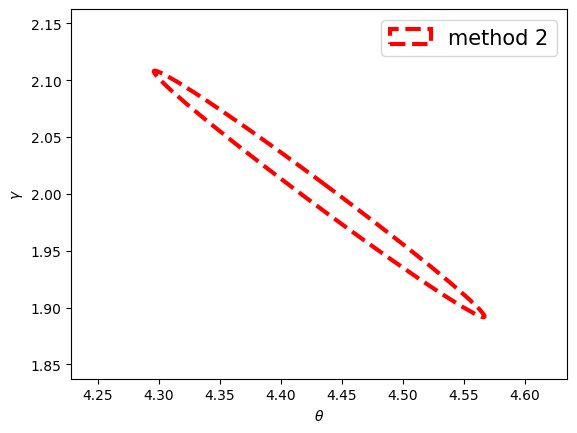

In [15]:
# We can now plot contours obtained so far 
p0_name = r'$\theta$'
p1_name = r'$\gamma$'
# pl.figure()
# plot_contours(F, params, fill=False,color='black',lw=3, label="method 1");
plot_contours(F_2, params_fid, fill=False, color='red', lw=3, linestyle='dashed', label="method 2");
pl.xlabel(p0_name)
pl.ylabel(p1_name);
pl.legend(fontsize=15)
